In [1]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
from salishsea_tools import geo_tools, geo_tools, tidetools
import functools
from IPython.display import clear_output
import datetime


%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [2]:
# Function used to get chlorophyll data from text files produced in 2003, 2004, 2005 cruises
def extract_data(file_path):
    file_description = []
    default_cols = ["STATION", "DATE", "TIME", "LAT", "LON"]
    time_loc_data = 5*["NaN"]
    data_list = []
    with open(file_path) as f:
            indata = False
            for line in f:
                if not indata:
                    if line.startswith("%"):
                        file_description.append(line)
                    elif line.startswith("*"):
                        split_line = line.split()
                        columns = split_line[1:len(split_line)]
                        num_cols = len(columns)
                        indata = True
                else:
                    split_line = line.split()
                    if not line.startswith("S") and not line.startswith("T") and not line.startswith("F") and not line.startswith("P") and len(split_line) == num_cols:
                        data_list.append(time_loc_data + split_line)
                    elif len(split_line) > 0:
                        try:
                            station = split_line[0]
                        except:
                            station = "NaN"
                        try:
                            date = split_line[2] + " " + split_line[3] + " " + split_line[4]
                            date = pd.to_datetime(date, infer_datetime_format=True)
                        except:
                            date = pd.to_datetime("NaN", infer_datetime_format=True, errors = "coerce")
                        try:
                            time = split_line[5]
                        except:
                            time = "NaN"
                        try:
                            lat = split_line[6] + " " + split_line[7]
                            lon = split_line[9] + " " + split_line[10]
                        except:
                            lat, lon = "NaN", "NaN"
                        time_loc_data = [station,date,time,lat,lon]
            
    return(pd.DataFrame(data_list, columns = default_cols + columns))

In [3]:
# Iterate through top level chlorophyll data directory, grabbing data from applicable files

basedir = "/ocean/shared/SoG/btl/"
chl_dict = dict()

for subdir in os.listdir(basedir):
    if os.path.isdir(basedir + '/' + subdir):
        for file in os.listdir(basedir + '/' + subdir):
            if file.startswith("bottle") and file.endswith(".txt"):
                chl_dict[subdir] = extract_data(basedir + "/" + subdir + "/" + file)
                break

In [4]:
# Convert from sexagesimal lat or lon string to decimal lat or lon float
def strToLatLon(s):
    try:
        split_str = s.split()
        return(float(split_str[0]) + float(split_str[1])/60)
    except:
        return(np.nan)

In [5]:
# Convert chlorophyll dataframe column types

all_chl = pd.concat(chl_dict, join = "inner")
all_chl.reset_index(inplace = True)

all_chl["DEPTH"] = pd.to_numeric(all_chl["depth"], errors='coerce')
all_chl["chl002"] = pd.to_numeric(all_chl["chl002"], errors='coerce')
all_chl["chl020"] = pd.to_numeric(all_chl["chl020"], errors='coerce')
all_chl["chl200"] = pd.to_numeric(all_chl["chl200"], errors='coerce')

all_chl["DECIMAL_LAT"] = (all_chl["LAT"].apply(strToLatLon))
all_chl["DECIMAL_LON"] = (all_chl["LON"].apply(strToLatLon))
all_chl["DECIMAL_LON"] = -all_chl["DECIMAL_LON"] # needs to be negative to match grid lon/lats
all_chl["STATION_LAT"] =  all_chl.groupby("STATION")["DECIMAL_LAT"].transform(np.median)
all_chl["STATION_LON"] =  all_chl.groupby("STATION")["DECIMAL_LON"].transform(np.median)

In [6]:
# Create smaller data frame with location of stations
station_lon_lat = all_chl[["STATION", "STATION_LON", "STATION_LAT"]].drop_duplicates()
station_lon_lat.columns = ["STATION", "LON", "LAT"]

In [7]:
# Add corresponding model points to station data frame
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

def closest_model_point_wrapper(lon, lat):
    try:
        model_point = geo_tools.find_closest_model_point(lon, lat, model_lons = X, model_lats = Y, grid = 'NEMO', land_mask = bathy.mask)
        return(model_point)
    except:
        print("ERROR" + str(lon) + " " + str(lat))
        return(np.nan)
    
station_lon_lat["MODEL_POINT"] = station_lon_lat.apply(lambda row: closest_model_point_wrapper(row[1], row[2]) , axis = 1)
station_lon_lat["MODEL_J"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[0])
station_lon_lat["MODEL_I"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[1])

In [8]:
# Choose which values to add to nowcast dataframe

tracers = ["PHY2"]

plot_months = ["mar"]

plot_hours = np.array([0, 12, 18])

max_depth = 20
result_depths = xr.open_dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/deptht_428m.nc').deptht.values
depth_indices = np.where(result_depths < max_depth)[0]

model_points = station_lon_lat["MODEL_POINT"]
model_js = [x[0] for x in model_points] 
model_is = [x[1] for x in model_points] 

stations = station_lon_lat["STATION"]

In [62]:
# Iterate through nowcast green results, grabbing certain tracers, locations, and dates/times
# Create pandas dataframe and save result

load_new_dataset = False

if load_new_dataset:
    nowcast_dir = "/results/SalishSea/nowcast-green/" #"/data/jpetrie/MEOPAR/SalishSea/results/nowcast_results/"

    month_num = {"jan": "01","feb": "02", "mar": "03", "apr": "04", "may": "05", "jun": "06", "jul": "07", "aug": "08", "sep": "09", "oct": "10", "nov": "11", "dec": "12" }

    dataframe_list = []
    num_files = 0
    start_time = datetime.datetime.now()
    for subdir in os.listdir(nowcast_dir):
        if os.path.isdir(nowcast_dir + '/' + subdir) and re.match("[0-9]{2}[a-z]{3}[0-9]{2}", subdir):
            month_str = subdir[2:5]
            date_str = "20" + subdir[5:7] + month_num[month_str] + subdir[0:2]
            tracer_file = "SalishSea_1h_" + date_str + "_" + date_str + "_ptrc_T.nc"
            tracer_path = nowcast_dir + "/" + subdir + "/" + tracer_file
            if os.path.isfile(tracer_path) and month_str in plot_months:
                grid_t = xr.open_dataset(tracer_path)
                result_hours = pd.DatetimeIndex(grid_t.time_centered.values).hour
                time_indices = np.where([(x in plot_hours) for x in result_hours])
                
                J, T, Z = np.meshgrid(model_js,time_indices,depth_indices, indexing = 'ij')
                I, T, Z = np.meshgrid(model_is,time_indices,depth_indices, indexing = 'ij')
                
                tracer_dataframes = []
                for t in tracers:
                    station_slice = grid_t[t].values[T,Z,J,I]
                    slice_xarray = xr.DataArray(station_slice,
                                     [stations,result_hours[time_indices], result_depths[depth_indices]],
                                     ["STATION", "HOUR", "DEPTH"], 
                                     t)
                    slice_dataframe = slice_xarray.to_dataframe()
                    slice_dataframe.reset_index(inplace = True)
                    tracer_dataframes.append(slice_dataframe)
                merged_tracers = functools.reduce(lambda left,right: pd.merge(left,right,on=["STATION", "HOUR", "DEPTH"]), tracer_dataframes)
                merged_tracers["DATE"] = pd.to_datetime(date_str, infer_datetime_format=True)
                merged_tracers["MONTH"] = int(month_num[month_str])
                dataframe_list.append(merged_tracers)

                num_files = num_files + 1
                run_time = datetime.datetime.now() - start_time
                clear_output()
                print("Files loaded:" + str(num_files))
                print("Date of most recent nowcast load: " + date_str)
                print("Time loading: ")
                print(run_time)
                print("\n\n\n")
                print(merged_tracers)

    nowcast_df = pd.concat(dataframe_list)    
    t = datetime.datetime.now()
    time_string = str(t.year) +"_"+ str(t.month) +"_"+ str(t.day) +"_"+ str(t.hour) +"_"+ str(t.minute)
    nowcast_df.to_pickle("/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/"+ time_string + ".pkl") 
    
else: 
    past_dataset_path = "/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/2016_8_8_11_24.pkl"
    nowcast_df = pd.read_pickle(past_dataset_path)

In [78]:
nowcast_df["DAY_OF_YEAR"] = nowcast_df["DATE"].apply(lambda x: x.dayofyear)
nowcast_df["DAY"] = nowcast_df["DATE"].apply(lambda x: x.day)
nowcast_df["MONTH"] = nowcast_df["DATE"].apply(lambda x: x.month)

In [17]:
# Linear model relating total diatoms with chlorophyll concentration
# from http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis-james/raw/tip/notebooks/chl_plankton_regression.ipynb
# Total diatoms (in nanogram carbon per litre) vs. chlorophyll larger than 20 micro meters (in micro grams per litre)

diat_chl_model = np.poly1d([ 28070.38412148,  64926.67728433])

In [18]:
# Convert model from nanogram carbon per litre to millimol Nitrogen per metre^3
# 10^-9 for nanogram Carbon -> gram Carbon
# 0.083259 for gram carbon -> mol Carbon
# 16/106 for mol carbon -> mol nitrogen
# 10^3 for mol nitrogen -> mmol nitrogen
# 1/(1/10^3) for 1/L -> 1/m^3

diat_chl_model = diat_chl_model*(10**-9)*(0.083259)*(16.0/106)*(10**3)*(10**3)

In [68]:
all_chl["YEAR"] = all_chl.DATE.apply(lambda x: x.year)
all_chl["MONTH"] = all_chl.DATE.apply(lambda x: x.month)
all_chl["DAY"] = all_chl.DATE.apply(lambda x: x.day)
all_chl["DATA_TYPE"] = "Estimated Diatoms"
all_chl["DIATOMS(mmolN/m3)"] = diat_chl_model(all_chl["chl200"])

In [80]:
def dateToString(date):
    try:
        date_string = date.strftime('%Y-%m-%d')
    except:
        date_string = "NULL"
    return(date_string)

nowcast_df["DATA_TYPE"] = "Simulated PHY2"
nowcast_df["DIATOMS(mmolN/m3)"] = nowcast_df["PHY2"]
combined = pd.concat([all_chl, nowcast_df.query("HOUR == 12")], ignore_index=True)
combined["IDENTIFIER"] = combined["DATA_TYPE"] + ", Date = " + combined["DATE"].apply(dateToString)

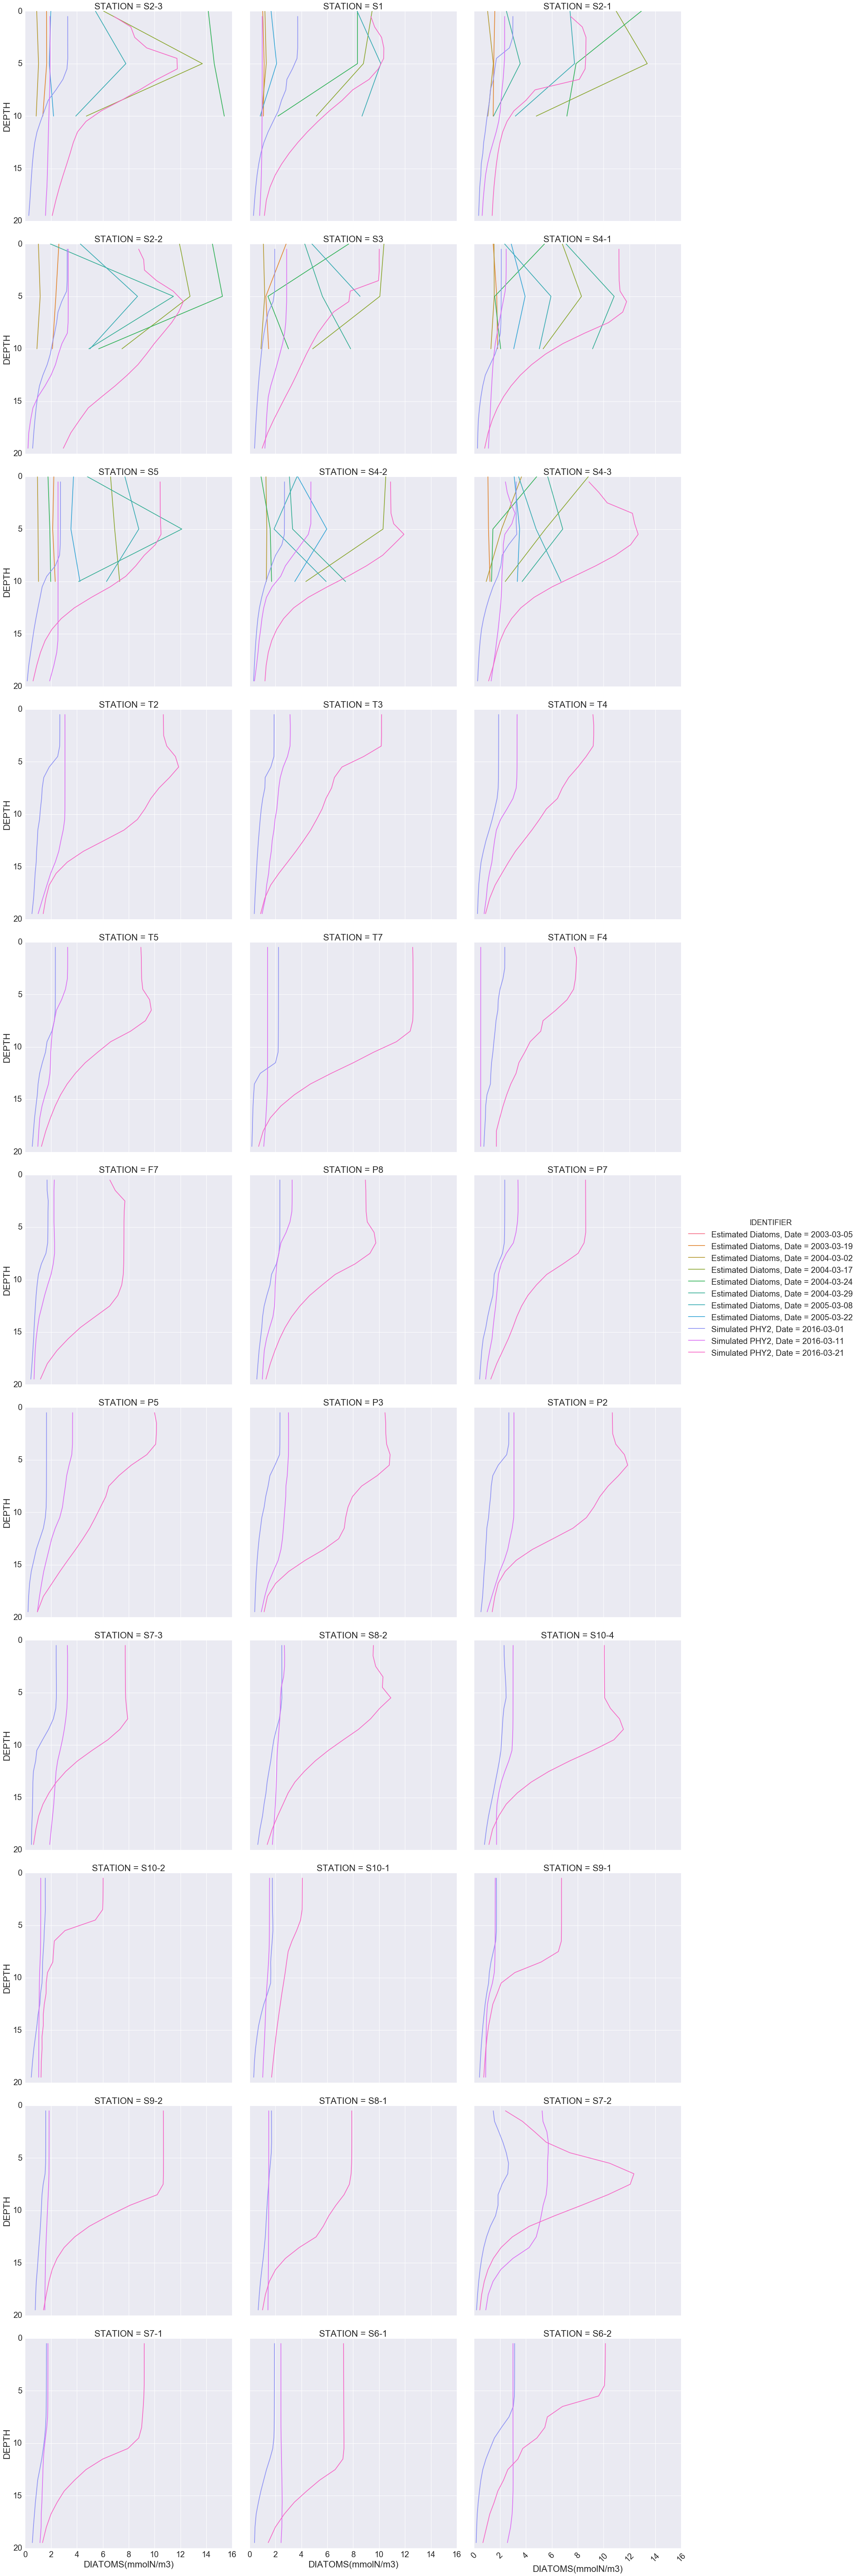

In [89]:
sns.set(font_scale = 2)
fg = sns.FacetGrid(data = combined[~pd.isnull(combined["DIATOMS(mmolN/m3)"]) & 
                                   (combined["MONTH"] == 3) & 
                                   ((combined["DATA_TYPE"] == "Estimated Diatoms") | (combined["DAY"]).isin([1,11,21]))], 
                   col = "STATION", col_wrap=3, hue = "IDENTIFIER", size =8, sharex = True, sharey = True)

fg.map(plt.plot, "DIATOMS(mmolN/m3)", "DEPTH").add_legend()
plt.xticks(rotation=45)
plt.gca().invert_yaxis()

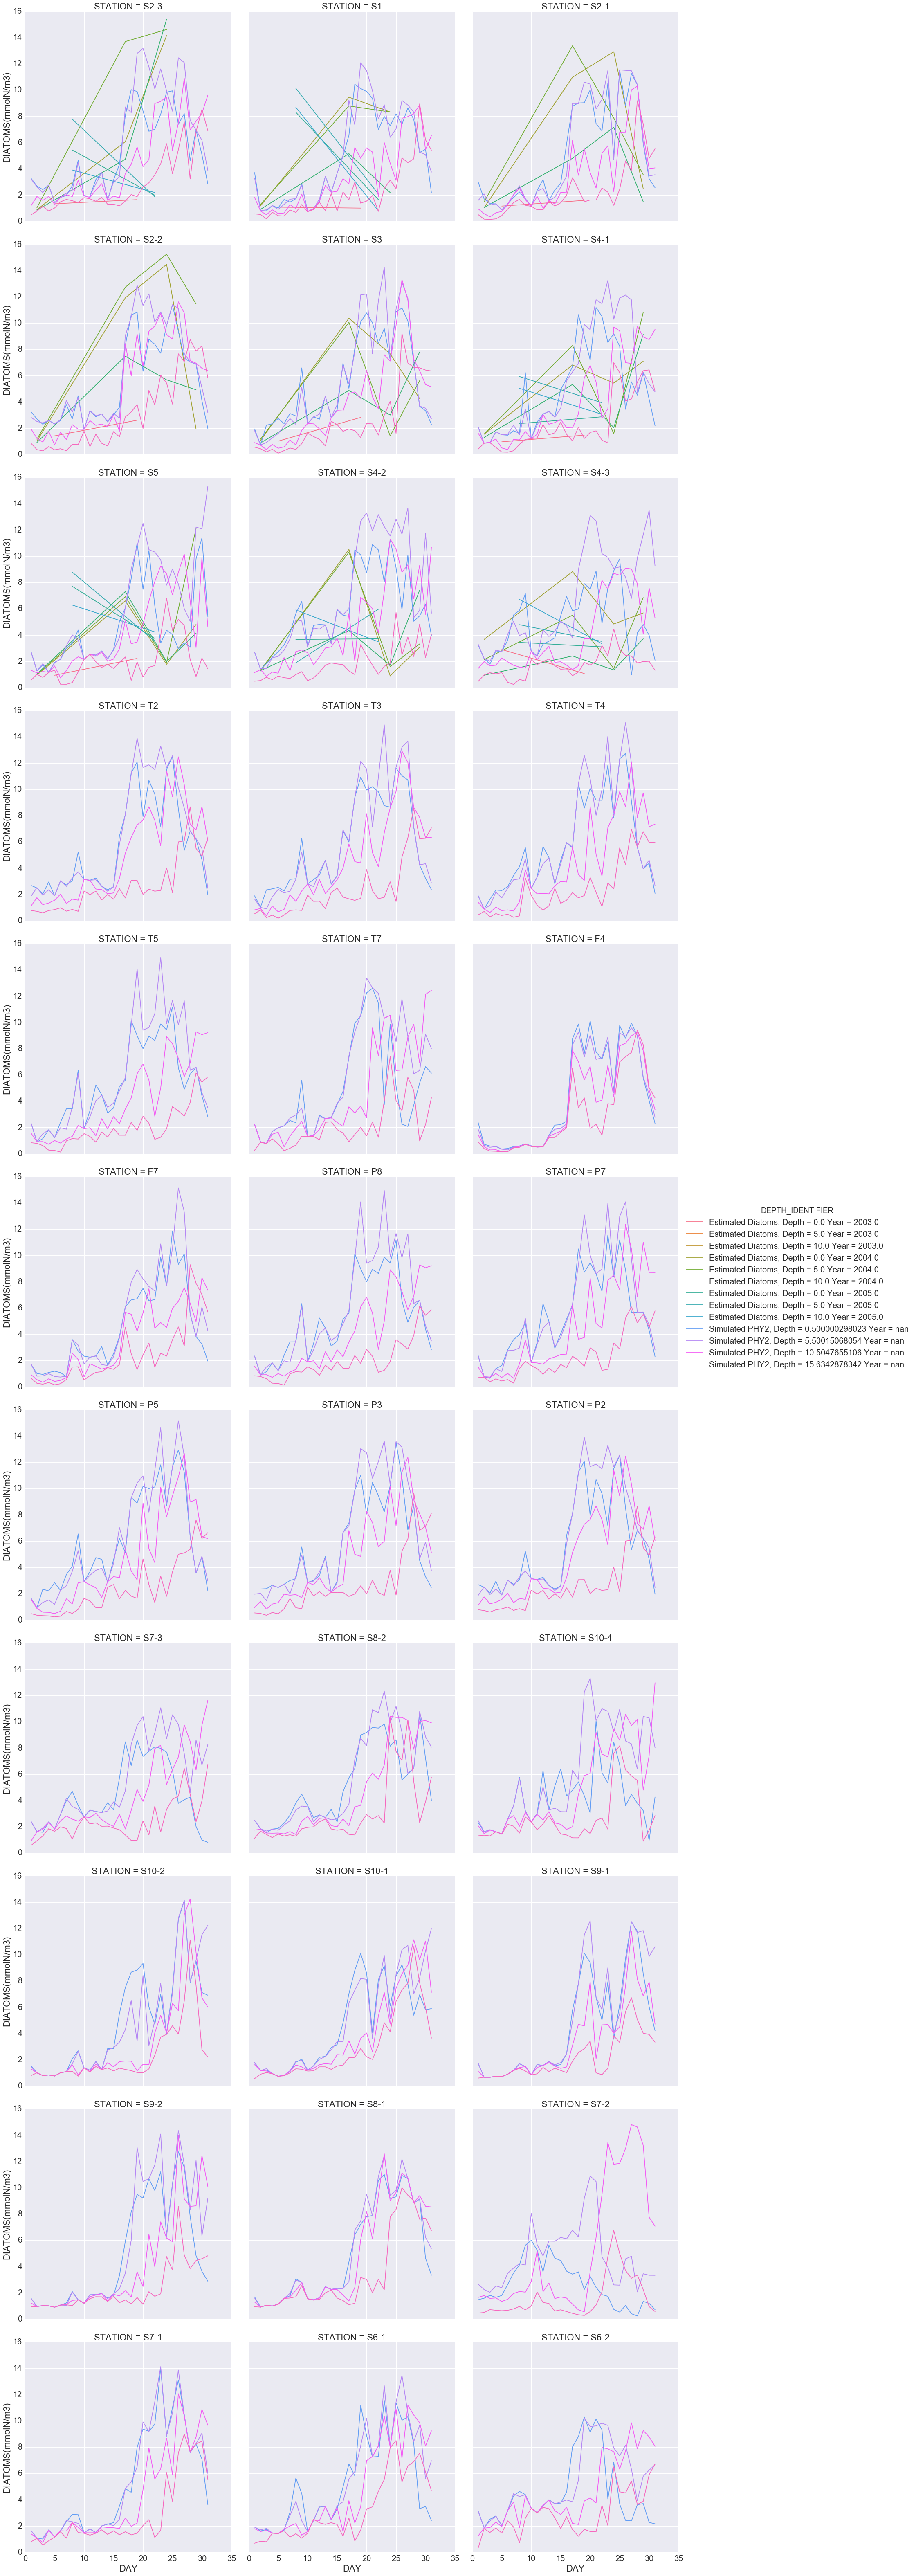

In [84]:
combined["DEPTH_IDENTIFIER"] = combined["DATA_TYPE"] + ", Depth = " + combined["DEPTH"].apply(str) + " Year = " + combined["YEAR"].apply(str)
combined.sort_values(["DEPTH_IDENTIFIER", "DATE"])
sns.set(font_scale = 2)
fg = sns.FacetGrid(data = combined[~pd.isnull(combined["DIATOMS(mmolN/m3)"]) & (combined["MONTH"] == 3) & (combined["DEPTH"]%5 < 1) ], col = "STATION", col_wrap=3, hue = "DEPTH_IDENTIFIER", size =8, sharex = True, sharey = True)
fg.map(plt.plot,"DAY", "DIATOMS(mmolN/m3)").add_legend()